# Churn Prediction of Telco Subscribers
So.... what is **churn**?
Churn is defined in business terms as ‘when a client cancels a subscription to a service they have been using.’ A common example is people cancelling Spotify/Netflix subscriptions. So, Churn Prediction is essentially predicting which clients are most likely to cancel a subscription i.e. ‘leave a company’ based on their usage of the service.

From a company point of view, it is necessary to gain this information because acquiring new customers is often arduous and costlier than retaining old ones. Hence, the insights gained from Churn Prediction helps them to focus more on the customers that are at a high risk of leaving.

The output in the case of Churn prediction is a simple yes or a no. That makes it a classification problem where you have to predict 1 if the customer is likely to churn and 0 otherwise.

In this project we will model contractual churn in the telecom business

# About the data
The dataset was provided by IBM Developer Platform and can be found [here](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

We'll be working with data of about 7K subscribers from whom 20 features have been collected. The data schema includes:
- **Demographic information:** gender, SeniorCitize, Partner, Dependents
- **Services signed up for:** PhoneService , MultipleLines , InternetService , OnlineSecurity , OnlineBackup , DeviceProtection , TechSupport , StreamingTV , StreamingMovies
- **Customer account info:** tenure , Contract , PaperlessBilling , PaymentMethod , MonthlyCharges , TotalCharges
- **Customer churn:** Churn

# Importing required dependencies

In [1]:
# import packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

plt.rcParams.update({'font.size': 13, 'figure.figsize': [8, 6]})

# Loading dataset

In [2]:
# read in the data
telco_raw = pd.read_csv(r'./data/telco.csv')
telco_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis
Let's check the data structure and see if it requires cleaning or any transformations.

In [3]:
telco_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
telco_raw.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The data has just over 7K rows and 21 columns. Most features are strings, except for tenure and monthly charges. Total charges feature needs further checks as it appears to have a string in it.

# Data visualization
Let's explore the data to find underlying patterns. For categorical columns, we'll plot graphs against the churn column.

In [5]:
gender = pd.DataFrame(telco_raw.groupby('gender')['Churn'].value_counts().unstack(0))
gender.columns.name=None
gender

,Female,Male
Churn,,
No,2549,2625
Yes,939,930


From the above table, we can see that gender isn't a contributing factor to customer churn in this dataset as their numbers of both genders, that is, whether churned or not, are about the same.

In [6]:
internet = pd.DataFrame(telco_raw.groupby('Churn')['InternetService'].value_counts().unstack(0))
internet.columns.name=None

,No,Yes
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
No,1413,113


In [17]:
# percentage values
round(internet.div(internet.sum(axis=1), axis=0)*100, 2)

,No,Yes
InternetService,,
DSL,81.04,18.96
Fiber optic,58.11,41.89
No,92.60,7.40


In [8]:
# function for styling graphs
def build_chart(data):
    """
        styling for graphs.
    """
    ax = data
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(color='grey')
    plt.yticks(color='grey')

Text(0, 0.5, '')

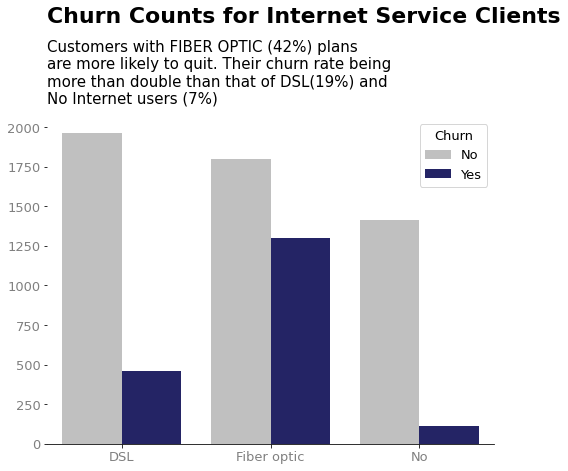

In [28]:
g=sns.countplot(x='InternetService', hue='Churn', data=telco_raw, palette=['silver', 'midnightblue'])
build_chart(g)
plt.title('Churn Counts for Internet Service Clients', loc='left', weight='bold', size=22, pad=95)
plt.text(-0.5, 2150, "Customers with FIBER OPTIC (42%) plans\nare more likely to quit. Their churn rate being\nmore than double than that of DSL(19%) and\nNo Internet users (7%)", size=15)
plt.xlabel('')
plt.ylabel('')

From the chart above we can see that people using Fibre Optice services have a higher churn rate. The company must improve on this service.

In [31]:
tech_support = pd.DataFrame(telco_raw.groupby('Churn')['TechSupport'].value_counts().unstack(0))
tech_support.columns.name=None
round(tech_support.div(tech_support.sum(axis=1), axis=0)*100, 2)

,No,Yes
TechSupport,,
No,58.36,41.64
No internet service,92.60,7.40
Yes,84.83,15.17


Text(0, 0.5, '')

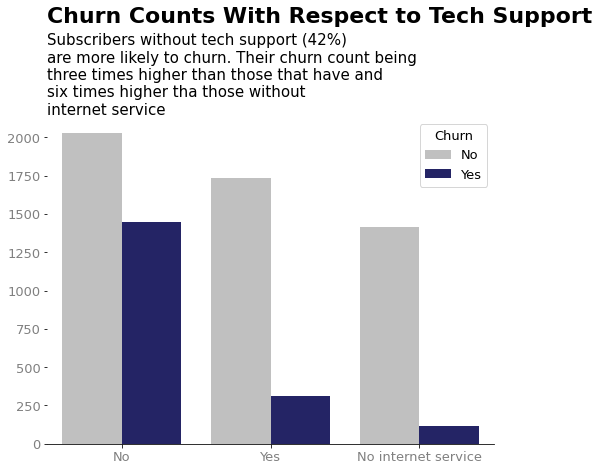

In [34]:
g=sns.countplot(x='TechSupport', hue='Churn', data=telco_raw, palette=['silver', 'midnightblue'])
build_chart(g)
plt.title('Churn Counts With Respect to Tech Support', loc='left', weight='bold', size=22, pad=95)
plt.text(-0.5, 2150, "Subscribers without tech support (42%)\nare more likely to churn. Their churn count being\nthree times higher than those that have and\nsix times higher tha those without\ninternet service", size=15)
plt.xlabel('')
plt.ylabel('')

Subscribers who don't have tech support tend to churn more.

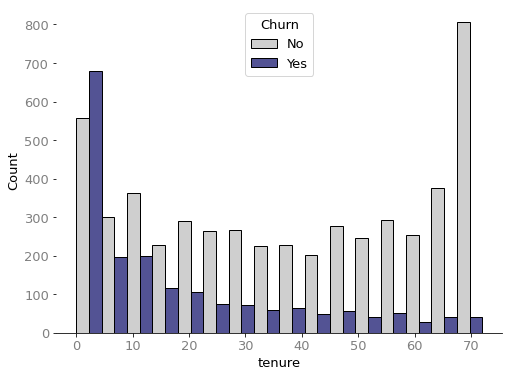

In [35]:
g = sns.histplot(x='tenure', hue='Churn', data=telco_raw, multiple='dodge', palette=['silver', 'midnightblue'])
build_chart(g)

Churn rates seem to be higher in the initial 5 months of tenure, about the time when new customers are taking the service through its paces, and deciding whether to keep or discard the subscription.

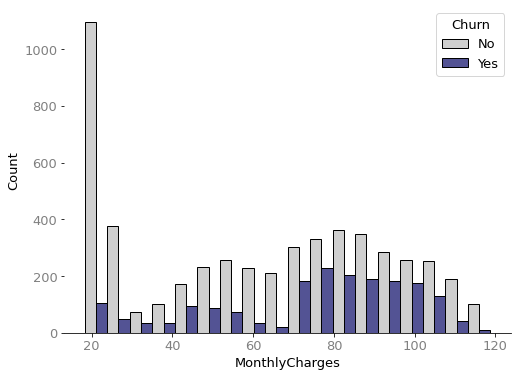

In [36]:
g = sns.histplot(x='MonthlyCharges', hue='Churn', data=telco_raw, multiple='dodge', palette=['silver', 'midnightblue'])
build_chart(g)

There's no particular trend in Monthly Charges related Churn. However, subscribers with charges between 70 and 100USD churned more than the rest.

# Data Preparation

We need to make sure that the data is in the right format to be used for predictions in ML. ML models don't work well with categorical inputs. Let's separate categorical and numerical columns and perform:
- one-hot encoding, and
- scaling.

In [37]:
# identify target and id columns
custid = ['customerID']
target = ['Churn']

# change the total charges feature to numeric and ffill nan values
telco_raw['TotalCharges'] = telco_raw['TotalCharges'].apply(pd.to_numeric, errors='coerce').fillna(method='ffill')

# get categorical and numerical columns and apply one hot encoding
categorical = telco_raw.nunique()[telco_raw.nunique()<10].keys().tolist()
categorical.remove(target[0])
numerical = [col for col in telco_raw.columns if col not in custid+target+categorical]
telco_raw = pd.get_dummies(data=telco_raw, columns=categorical, drop_first=True)

# scaling numerical columns
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(telco_raw[numerical])
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

# pputting it all together
telco_raw = telco_raw.drop(columns=numerical, axis=1)
telco = telco_raw.merge(right=scaled_numerical, how='left', left_index=True, right_index=True)

# Machine Learning
What we'll do:
- Split data to training and testing sets
- Initialize the training model 
- Predict values on testing data 
- Measure performance on testing data 

The machine learning models we'll compare for accuracy include:
- Decision Tree Classifier
- Logistic Regression
- Random Forest Classifier
- XGBoost

To evaluate the effectiveness of these models, we will use precision and recall. Precision will give us the proportion of positive identifications that were indeed correct, while recall will determine the proportion of real positivies that were correctly identified.
Considering the kind of problem at hand, recall should be suitable for this project, as the objective is to identify the maximum number of clients that are prone to churn.

In [38]:
X = telco.drop(['customerID', 'Churn'], axis=1)
Y = telco['Churn']
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=43)

## Decision Tree Classifier

In [39]:
# hyperparameter tuning
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list


for i in range(len(depth_list)):
    dtc = tree.DecisionTreeClassifier(max_depth=depth_list[i])
    dtc.fit(train_x, train_y)
    pred_test_y = dtc.predict(test_x)
    depth_tuning[i, 1] = accuracy_score(test_y, pred_test_y)
    depth_tuning[i, 2] = precision_score(test_y, pred_test_y, pos_label='Yes')
    depth_tuning[i, 3] = recall_score(test_y, pred_test_y, pos_label='Yes')

cols = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(depth_tuning, columns=cols).style.highlight_max(axis=0, color='red')

,Max_Depth,Accuracy,Precision,Recall
0,2.000000,0.797842,0.687500,0.426724
1,3.000000,0.797842,0.687500,0.426724
2,4.000000,0.797842,0.687500,0.426724
3,5.000000,0.795003,0.623501,0.560345
4,6.000000,0.784214,0.619318,0.469828
5,7.000000,0.782510,0.621622,0.446121
6,8.000000,0.767178,0.557203,0.566810
7,9.000000,0.758092,0.547030,0.476293
8,10.000000,0.753549,0.531646,0.543103
9,11.000000,0.754117,0.532909,0.540948


In [40]:
# tuned Decision Tree Classifier
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(train_x, train_y)
pred_test_y = dtc.predict(test_x)
dtc_accuracy = accuracy_score(test_y, pred_test_y)
print(f'Accuracy Score: {dtc_accuracy}')

# import graphviz

# exported = tree.export_graphviz(decision_tree=dtc, out_file=None, feature_names=train_x.columns, precision=1, class_names=['Not chunr', 'Churn'], filled=True)
# graph = graphviz.Source(exported)
# display(graph)

Accuracy Score: 0.7950028392958546


# Logistic Regression
## Logistic Regression Coefficients
These can be interpreted as change in log-odds of churn associated with 1 unit increase in the feature. They're a tad difficult to interpret, so the solution is to calculate an exponent of the coefficients, giving us the change in odds associated with 1 unit increase in the feature.

In [41]:
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
pred_test_y = logreg.predict(test_x)
coefficients = pd.concat([pd.DataFrame(train_x.columns), pd.DataFrame(np.transpose(logreg.coef_))], axis=1)
coefficients.columns = ['Feature', 'Coefficient']
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients.sort_values(by='Coefficient'))
logreg_accuracy = accuracy_score(test_y, pred_test_y)
print(f'Accuracy Score: {logreg_accuracy}')


                                  Feature  Coefficient  Exp_Coefficient
27                                 tenure    -1.391798         0.248628
22                      Contract_Two year    -1.337359         0.262538
21                      Contract_One year    -0.701149         0.496015
10                     OnlineSecurity_Yes    -0.424509         0.654091
4                        PhoneService_Yes    -0.313958         0.730549
16                        TechSupport_Yes    -0.299464         0.741216
3                          Dependents_Yes    -0.242629         0.784562
12                       OnlineBackup_Yes    -0.166382         0.846723
26             PaymentMethod_Mailed check    -0.131695         0.876608
9      OnlineSecurity_No internet service    -0.099999         0.904838
17        StreamingTV_No internet service    -0.099999         0.904838
15        TechSupport_No internet service    -0.099999         0.904838
19    StreamingMovies_No internet service    -0.099999         0

## Random Forest Classifier

In [42]:
rfc = RandomForestClassifier()

param_grid = {'n_estimators':[int(x) for x in np.linspace(start=200,stop=1200,num=11)],
            'max_features':['auto','sqrt'],
            'max_depth':[int(x) for x in np.linspace(start=10,stop=100,num=11)],
            'min_samples_leaf':[1,2,3,5],'min_samples_split':[2,5,10,15]}
rcv = RandomizedSearchCV(rfc, param_grid,cv=3,verbose=2,random_state=43)
rcv.fit(train_x, train_y)
best_random = rcv.best_estimator_
predict_cv = best_random.predict(test_x)
rfc_accuracy = accuracy_score(test_y, predict_cv)
print(f'Accuracy Score: {rfc_accuracy}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=55, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=55, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=55, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END max_depth=91, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.7s
[CV] END max_depth=91, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END max_depth=91, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.3s
[CV] END max_depth=64, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END max_depth=64, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   2.4s
[CV] END max_depth=64, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   2.1s
[CV] END max_depth=64, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=600; total time=   1.9s
[CV] END max_depth=64, max_features=sqr

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=37, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=37, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=37, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=28, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=28, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:422: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=28, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1100; total time=   3.7s
Accuracy Score: 0.80465644520159


# XGBoost

In [43]:
xgb = XGBClassifier()
xgb.fit(train_x, train_y)
pred_y = xgb.predict(test_x)
xgb_accuracy = accuracy_score(test_y, pred_y)
print(f'Accuracy Score: {xgb_accuracy}')

[00:19:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score: 0.7915956842703009


In [44]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3)
kmeans.fit(telco.drop(['customerID', 'Churn'], axis=1))
telco['Cluster'] = kmeans.labels_
telco.groupby('Cluster').mean()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.504438,0.192531,0.339761,0.209979,0.839302,0.160698,0.323538,0.510560,0.0,0.0,...,0.339149,0.124885,0.029691,0.664524,0.149066,0.483012,0.215182,-0.683291,0.107563,-0.549232
1,0.501333,0.204889,0.690667,0.347111,0.930222,0.069778,0.698667,0.634667,0.0,0.0,...,0.721778,0.311556,0.426667,0.690667,0.312889,0.295556,0.074667,1.042512,0.828481,1.279443
2,0.510485,0.034076,0.483617,0.421363,1.000000,0.000000,0.224115,0.000000,1.0,1.0,...,0.000000,0.238532,0.418087,0.292267,0.216907,0.079948,0.485583,-0.074273,-1.451829,-0.710620


<AxesSubplot:xlabel='Cluster'>

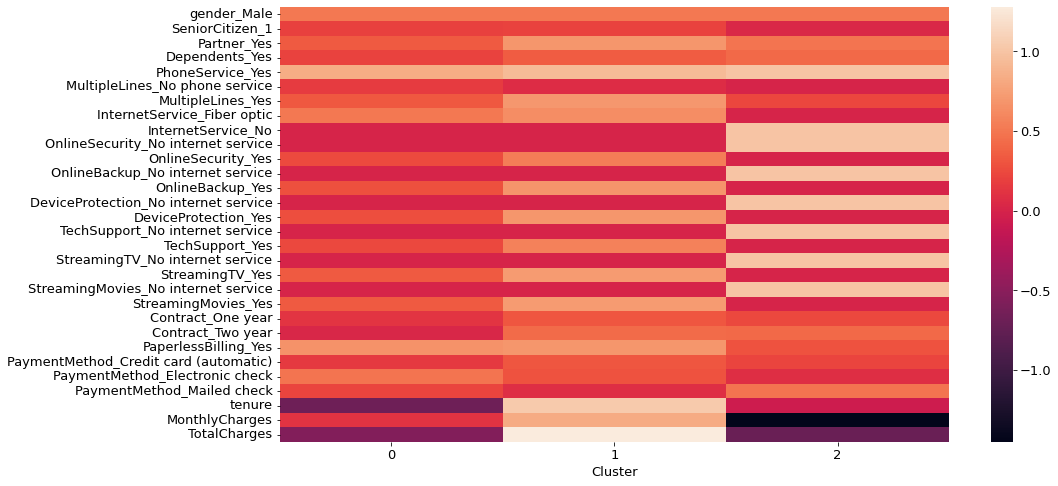

In [45]:
plt.figure(figsize=(15,8))
sns.heatmap(telco.groupby('Cluster').mean().T)


## Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)
pred_train_y = logreg.predict(train_x)
pred_test_y = logreg.predict(test_x)
train_accuracy = accuracy_score(train_y, pred_train_y)
test_accuracy = accuracy_score(test_y, pred_test_y)
print('Training accuracy:', round(train_accuracy, 4))
print('Test accuracy:', round(test_accuracy, 4))

Training accuracy: 0.8052
Test accuracy: 0.8024


In [47]:
from sklearn.metrics import precision_score, recall_score

train_precision = round(precision_score(train_y, pred_train_y, pos_label='Yes'), 4)
test_precision = round(precision_score(test_y, pred_test_y, pos_label='Yes'), 4)
test_recall = round(recall_score(test_y, pred_test_y, pos_label='Yes'), 4)
train_recall = round(recall_score(train_y, pred_train_y, pos_label='Yes'))

print('Training precision: {}, Training recall: {}'.format(train_precision, train_recall))
print('Testing precision: {}, Testing recall: {}'.format(test_precision, test_recall))

Training precision: 0.6604, Training recall: 1
Testing precision: 0.6443, Testing recall: 0.5582


# Regularization
Lets introduce a penalty coefficient to address overfitting in order to mak the model more generalizable to unseeen samples.

In [48]:
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C

for i in range(0, len(C)):
    logreg = LogisticRegression(penalty='l1', C=C[i], solver='liblinear')
    logreg.fit(train_x, train_y)
    pred_test_y = logreg.predict(test_x)
    l1_metrics[i, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[i, 2] = accuracy_score(test_y, pred_test_y)
    l1_metrics[i, 3] = precision_score(test_y, pred_test_y, pos_label='Yes')
    l1_metrics[i, 4] = recall_score(test_y, pred_test_y, pos_label='Yes')

cols = ['C', 'Non-Zero Coeffs', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(l1_metrics, columns=cols).style.highlight_max(color='red', axis=0)

,C,Non-Zero Coeffs,Accuracy,Precision,Recall
0,1.000000,22.000000,0.797842,0.635678,0.545259
1,0.500000,21.000000,0.800114,0.642857,0.543103
2,0.250000,21.000000,0.801817,0.647059,0.545259
3,0.100000,17.000000,0.803521,0.652850,0.543103
4,0.050000,16.000000,0.800114,0.650538,0.521552
5,0.025000,13.000000,0.796706,0.648876,0.497845
6,0.010000,9.000000,0.798410,0.686007,0.433190
7,0.005000,3.000000,0.788189,0.711628,0.329741
8,0.002500,2.000000,0.737081,1.000000,0.002155


In [49]:
accuracies = [dtc_accuracy, logreg_accuracy, rfc_accuracy, xgb_accuracy]
models = ['DecisionTreeClassifier', 'LogisticRegression', 'RandomForestClassifier', 'XGBoost']

results = {}

for model, accuracy in zip(models, accuracies):
    results[model] = accuracy

results_items = results.items()
results_list = list(results_items)
pd.DataFrame(results_list, columns=['Model','Accuracy']).style.highlight_max(subset='Accuracy', color='red')

,Model,Accuracy
0,DecisionTreeClassifier,0.795003
1,LogisticRegression,0.802385
2,RandomForestClassifier,0.804656
3,XGBoost,0.791596


From the variety of models, we see that Random Forest outperforms the others by using RandomCV.

# Conclusion
We've gone through various tasks involved in Churn Prediction in this project. Note that finding patterns in EDA is just as important as the final prediction model. Churn prediction tasks often remain incomplete if patterns aren't found in the data through EDA.